In [1]:
import skimage.io
import skimage.color
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [0]:
#######################################################
# - อ่านไฟล์ภาพ
# - resize ภาพให้มีขนาด 20x20x3
# - convert จาก RGB เป็น Gray scale
#######################################################

DATASET_DIR = 'Lao-License-recognition/dataset/ann'

classes = os.listdir(DATASET_DIR)
data = []

for cls in classes:
  class_dir = os.path.join(DATASET_DIR, cls)
  files = os.listdir(class_dir)
  for f in files:
    img = skimage.io.imread(os.path.join(class_dir, f)) # อ่านพิกเซลของภาพ (พิกเซลมีค่า 0-255)
    img2 = skimage.transform.resize(img, (20,20,3)) # ปรับขนาดภาพเป็น 20x20 พิกเซล (พิกเซลมีค่า 0-1)
    img = skimage.color.rgb2gray(img2) # แปลงเป็น gray scale (พิกเซลมีค่า 0-1)
    #img = skimage.util.invert(img) # กลับค่าสี (optional) (พิกเซลมีค่า 0-1)
    img = (img - img.min())/(img.max() - img.min()) # ปรับยืดความสว่างและมืดของภาพ (พิกเซลมีค่า 0-1)
    data.append({
        'x': img,
        'y': cls
    })
    #print(F'{img.min()}, {img.max()}')
    
random.shuffle(data)

In [0]:
X = [d['x'] for d in data]
y = [d['y'] for d in data]

# เพิ่มข้อมูลที่มีการรบกวน
X.extend([dx + 0.2*np.random.randn(20,20) for dx in X])
y.extend(y)

# สลับภาพหลังจากเพิ่มภาพเติมแต่ง
shf_ind = list(range(len(X)))
random.shuffle(shf_ind)
X = np.array(X)[shf_ind]
y = np.array(y)[shf_ind]


ys = list(np.unique(y))
y = [ys.index(v) for v in y]

x_train = np.array(X[:int(len(X)*0.8)])
y_train = np.array(y[:int(len(X)*0.8)])

x_test = np.array(X[int(len(X)*0.8):])
y_test = np.array(y[int(len(X)*0.8):])

In [0]:
batch_size = 128
num_classes = len(classes)
epochs = 200

# input image dimensions
img_rows, img_cols = 20, 20

In [7]:
num_classes

30

In [0]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

x_train = extend_channel(x_train)
x_test = extend_channel(x_test)

input_shape = x_train.shape[1:]

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# ไม่ต้อง normalize ด้วย 255 แล้ว เพราะค่า x แต่ละพิกเซลมีค่าระหว่าง 0.0 - 1.0
#x_train /= 255
#x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train2 = keras.utils.to_categorical(y_train, num_classes)
y_test2 = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (2563, 20, 20, 1)
2563 train samples
641 test samples


In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [16]:
history = model.fit(x_train, y_train2,
          batch_size=batch_size,
          #epochs=1000,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test2))

Train on 2563 samples, validate on 641 samples
Epoch 1/200
2563/2563 [==============================] - 0s 136us/step - loss: 0.0018 - acc: 0.9992 - val_loss: 7.1119e-04 - val_acc: 1.0000
Epoch 2/200
2563/2563 [==============================] - 0s 133us/step - loss: 0.0022 - acc: 0.9992 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3/200
2563/2563 [==============================] - 0s 129us/step - loss: 0.0016 - acc: 0.9992 - val_loss: 6.7654e-04 - val_acc: 1.0000
Epoch 4/200
2563/2563 [==============================] - 0s 130us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 6.8328e-04 - val_acc: 1.0000
Epoch 5/200
2563/2563 [==============================] - 0s 128us/step - loss: 0.0022 - acc: 0.9992 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 6/200
2563/2563 [==============================] - 0s 127us/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0037 - val_acc: 0.9984
Epoch 7/200
2563/2563 [==============================] - 0s 129us/step - loss: 0.0032 - acc: 0.9988 - val_loss: 0.0015 

In [17]:
score = model.evaluate(x_test, y_test2, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.000385402018211953
Test accuracy: 1.0


In [0]:
model.save_weights('char_cnn.h5')

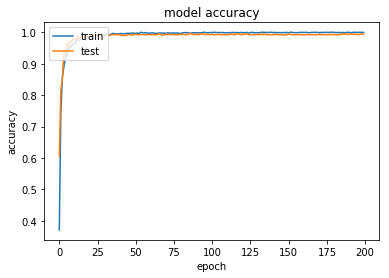

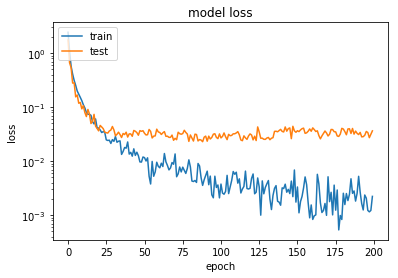

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

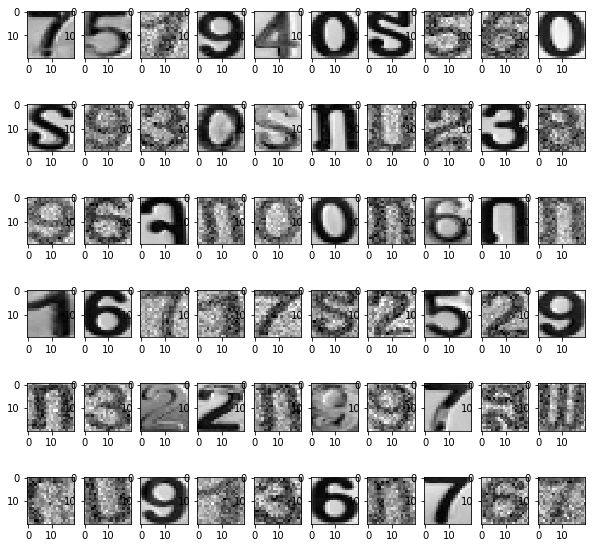

In [0]:
ncol = 10
nrow = 6

fig, axs = plt.subplots(nrow, ncol, figsize=(10, 10))

for r in range(nrow):
  for c in range(ncol):
    axs[r][c].imshow(x_test[r*ncol+c].reshape((20, 20)), cmap='gray')
plt.show()

In [0]:
#model.predict_classes(x_test)
print([ys[c] for c in model.predict_classes(x_test)])

['ກ', 'ກ', '3', 'ສ', '8', '6', '5', '2', '3', '3', '8', '8', '1', '6', '8', 'ຄ', 'ກ', '3', 'ວ', '8', '0', 'ຣ', 'ກ', '5', '4', '6', 'ຫ', '6', 'ວ', '5', 'ສ', '0', '1', '7', '9', '2', '8', 'ກ', 'ອ', '6', '5', '3', 'ຕ', 'ກ', '9', '5', '3', 'ກ', '7', '7', '2', 'ກ', '0', '8', '4', '7', 'ກ', '6', '8', 'ກ', '4', '2', '3', 'ມ', '9', '4', '8', 'ອ', '6', '0', '5', 'ກ', 'ຄ', 'ກ', '0', 'ກ', 'ຂ', 'ກ', '0', '8', '7', 'ຄ', 'ດ', '5', '2', '8', '5', 'ຮ', '2', '8', '7', '9', 'ກ', 'ຈ', '1', '3', 'ນ', '0', '6', 'ຍ', 'ຂ', 'ຜ', '9', 'ກ', 'ພ', '0', 'ດ', 'ກ', 'ຮ', 'ຍ', '6', '5', '8', '9', 'ນ', 'ກ', '3', '5', '1', '2', '1', '0', '3', '8', '0', '1', '7', '2', 'ກ', '4', '3', 'ກ', '0', '1', '4', 'ນ', '1', 'ພ', 'ຮ', '0', '6', '2', 'ຂ', '3', 'ຍ', '8', '4', '3', 'ດ', 'ກ', '1', '6', '3', '3', '8', '6', '0', 'ກ', '3', '9', '7', '6', '4', '9', '2', '1', '0', 'ຮ', '0', '8', 'ສ', 'ຄ', '5', 'ດ', 'ຜ', '2', 'ຄ', '9', '6', 'ກ', '6', 'ກ', '7', '5', '7', 'ຍ', '9', '9', '9', '0', 'ກ', 'ກ', 'ຜ', '7', 'ກ', '5', 'ຄ', 'ກ', '6', '9',

In [0]:
y_test

array([10, 10,  3, 26,  8,  6,  5,  2,  3,  3,  8,  8,  1,  6,  8, 12, 10,
        3, 25,  8,  0, 23, 10,  5,  4,  6, 27,  6, 25,  5, 26,  0,  1,  7,
        9,  2,  8, 10, 28,  6,  5,  3, 16, 10,  9,  5,  3, 10,  7,  7,  2,
       10,  0,  8,  4,  7, 10,  6,  8, 10,  4,  2,  3, 22,  9,  4,  8, 28,
        6,  0,  5, 10, 12, 10,  0, 10, 11, 10,  0,  8,  7, 12, 15,  5,  2,
        8,  5, 29,  2,  8,  7,  9, 10, 13,  1,  3, 18,  0,  6, 14, 11, 20,
        9, 10, 21,  0, 15, 10, 29, 14,  6,  5,  8,  9, 18, 10,  3,  5,  1,
        2,  1,  0,  3,  8,  0,  1,  7,  2, 10,  4,  3, 10,  0,  1,  4, 18,
        1, 21, 29,  0,  6,  2, 11,  3, 14,  8,  4,  3, 15, 10,  1,  6,  3,
        3,  8,  6,  0, 10,  3,  9,  7,  6,  4,  9,  2,  1,  0, 29,  0,  8,
       26, 12,  5, 15, 20,  2, 12,  9,  6, 10,  6, 10,  7,  5,  7, 14,  9,
        9,  9,  0, 10, 10, 20,  7, 10,  5, 12, 10,  6,  9, 20,  3, 11,  4,
        2,  6, 28,  8,  9,  9, 11, 11, 28, 15,  3,  2,  3, 13,  7,  4,  0,
        2,  5,  5,  1, 11

In [0]:
ys

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'ກ',
 'ຂ',
 'ຄ',
 'ຈ',
 'ຍ',
 'ດ',
 'ຕ',
 'ທ',
 'ນ',
 'ບ',
 'ຜ',
 'ພ',
 'ມ',
 'ຣ',
 'ລ',
 'ວ',
 'ສ',
 'ຫ',
 'ອ',
 'ຮ']

In [0]:
y_predict = model.predict_classes(x_test)

indx_error = np.where(y_test!=y_predict)
indx_error

(array([ 96, 435]),)

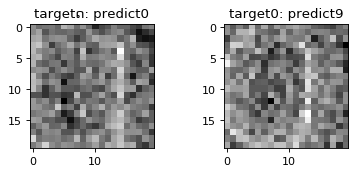

In [0]:
test_err = y_test[indx_error]
prid_err = y_predict[indx_error]

plt.figure(figsize=(12, indx_error[0].shape[0]*14//4), dpi= 80, facecolor='w', edgecolor='k')
for i in range(indx_error[0].shape[0]):
    plt.subplot(int(indx_error[0].shape[0])+1,4,i+1)
    plt.imshow(x_test[indx_error[0][i]].reshape((20,20)), cmap='gray', interpolation='none')
    plt.title('target{}: predict{}'.format(ys[test_err[i]], ys[prid_err[i]]))

plt.show()